# Redes Neurais - Trabalho 1

#### Mushroom classification

All images were downloaded from the website [flickr](https://flickr.com/).

Trained classes:
- Amanita gemmata
- Amanita muscaria
- Amanita pantherina
- Amanita phalloides
- Clathrus archeri
- Coprinellus disseminatus
- Coprinus comatus
- Entoloma hochstetteri
- Filoboletus manipularis
- Fomes fomentarius
- Gyromitra esculenta
- Hericium erinaceus
- Hydnellum peckii
- Ileodictyon cibarium
- Lepiota cristata
- Morchella esculenta
- Phallus indusiatus
- Psilocybe cubensis
- Psilocybe semilanceata
- Trametes versicolor

Each class has 100 images

Telegram bot: https://t.me/ufms_lab_mushroom_ai_bot / @ufms_lab_mushroom_ai_bot

Drive shared directory with the images: https://drive.google.com/drive/folders/1rvbcnV32ABlbG8ye3PeuPfqSs68Upj2-?usp=sharing


## Configuration

### Libraries

In [3]:
import os
import time
import copy
from PIL import Image,ImageStat
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
from torch import optim 
from torch.utils.data import Dataset
from typing import Any,Tuple
import torchvision.transforms as transforms
from torchvision import datasets, models
import torchsummary
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import pandas as pd
import seaborn as sn
from torchvision.utils import make_grid

from torchvision.models.efficientnet import efficientnet_b2
from torchvision.models.regnet import regnet_y_800mf
from torchvision.models.shufflenetv2 import shufflenet_v2_x2_0

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

### Variables

In [6]:
batch_size=20
input_size=224
dir = './classes'
patience_time=15
criterion = nn.CrossEntropyLoss()

### Dataset & Dataloader

In [7]:
class MushroomsDataset(Dataset):
    def __init__(self,dir,transform=None,target_transform=None,loader = None):
        self.main_dir = dir
        self.transform = transform
        self.target_transform = target_transform
        self.classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        self.classes.sort()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.targets = []
        self.instances = self.makeInstances()
        self.loader = loader
        
        if loader is None:
            self.loader = lambda x: Image.open(x).convert('RGB')

    def makeInstances(self):
        instances = []
        targets = []
        for target_class in sorted(self.class_to_idx.keys()):
                class_index = self.class_to_idx[target_class]
                target_dir = os.path.join(self.main_dir, target_class)
                for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                    for fname in sorted(fnames):
                        path = os.path.join(root, fname)
                        item = path, class_index
                        targets.append(class_index)
                        instances.append(item)
        self.targets = torch.tensor(targets)
        return instances
    def __getitem__(self,index:int) -> Tuple[Any,Any]:
        path, target = self.instances[index]
        instance = self.loader(path)
        if self.transform is not None:
            instance = self.transform(instance)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return instance,target
    def __len__(self) -> int:
        return len(self.instances)

In [8]:
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                            ])

In [9]:
dataset = MushroomsDataset(dir,transform=transform)
train_idx, temp_idx = train_test_split(np.arange(len(dataset)),test_size=0.3,shuffle=True,stratify=dataset.targets)
valid_idx, test_idx = train_test_split(temp_idx,test_size=0.5,shuffle=True,stratify=dataset.targets[temp_idx])
 
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)
test_sampler  = torch.utils.data.SubsetRandomSampler(test_idx)
 
dl_train = torch.utils.data.DataLoader(dataset,batch_size=batch_size,sampler=train_sampler)
dl_valid = torch.utils.data.DataLoader(dataset,batch_size=batch_size,sampler=valid_sampler)
dl_test  = torch.utils.data.DataLoader(dataset,batch_size=batch_size,sampler=test_sampler)

### Images

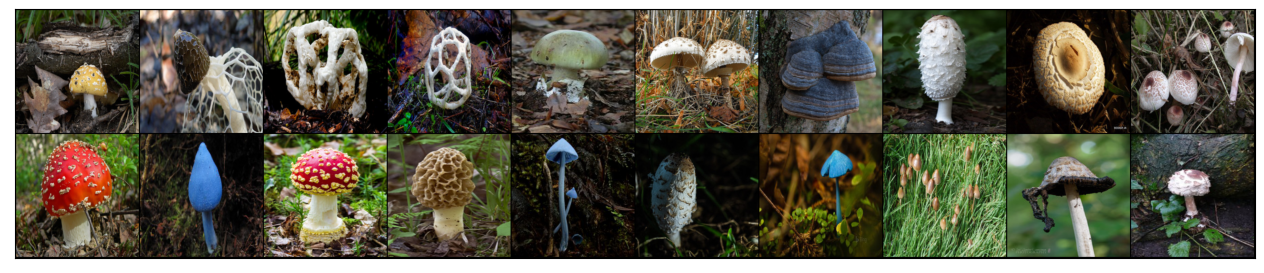

In [10]:
for images, labels in dl_train:
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=10).permute(1, 2, 0))
    break

### Functions

In [11]:
def trainModel(model, optimizer):
  stop = False
  epoch = 0
  lowest_loss_eval = 10000
  last_best_result = 0
  loss_train = []
  loss_eval  = []
  while (not stop):
      model.train()
      lloss = []
      for x,y in dl_train:
          x = x.to(device)
          y = y.to(device)
          pred = model(x)
          closs = criterion(pred,y)
          closs.backward()
          optimizer.step()
          optimizer.zero_grad()
          lloss.append(closs.item())
      loss_train.append(np.mean(lloss))
      llos = []
      model.eval()
      lres = []
      ytrue = []
      with torch.no_grad():
          for data,y in dl_valid:
              data = data.to(device)

              pred = model(data)
              closs = criterion(pred.cpu(),y)
              lloss.append(closs.item())
              res  = pred.argmax(dim=1).cpu().tolist()
              lres += res
              ytrue += y
      avg_loss_eval = np.mean(lloss)
      loss_eval.append(avg_loss_eval)
      if avg_loss_eval < lowest_loss_eval:
          lowest_loss_eval = avg_loss_eval 
          last_best_result = 0
          print("Best model found! saving...")
          actual_state = {
              'optim': optimizer.state_dict(),
              'model': model.state_dict(),
              'epoch': epoch,
              'loss_train': loss_train,
              'loss_eval': loss_eval
          }
          torch.save(actual_state,f'model_{model.name}.pth')
      last_best_result += 1
      if last_best_result > patience_time:
          stop = True
      print("epoch %d loss_train %4.3f loss_eval %4.3f last_best %d"%(epoch,loss_train[-1],loss_eval[-1],last_best_result))
      epoch += 1

In [12]:
def recoverTrainedModel(model, optimizer):
    recover = torch.load(f'model_{model.name}.pth')
    optimizer.load_state_dict(recover['optim'])
    model.load_state_dict(recover['model'])

    return model, recover

In [13]:
def modelMetrics(model):
    model.eval()
    lres = []
    ytrue = []
    with torch.no_grad():
        for data,target in dl_test:
            data = data.to(device)
            pred = model(data)
            res  = pred.argmax(dim=1).cpu().tolist()
            lres += res
            ytrue += target
    return ytrue, lres

## Without Pre-treined Weights

### Model - efficientnet_b2 (9.1M Params)

In [281]:
efficientnet_model = efficientnet_b2()
efficientnet_model.classifier[1] = torch.nn.Linear(1408, len(dataset.classes))
efficientnet_model.num_classes = len(dataset.classes)
efficientnet_model.name = 'efficientnet_b2'
efficientnet_model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [282]:
efficientnet_optimizer = optim.SGD(efficientnet_model.parameters(), lr=0.001, momentum=0.9)

In [283]:
trainModel(efficientnet_model, efficientnet_optimizer)

Best model found! saving...
epoch 0 loss_train 2.956 loss_eval 2.959 last_best 1
epoch 1 loss_train 2.858 loss_eval 3.502 last_best 2
Best model found! saving...
epoch 2 loss_train 2.743 loss_eval 2.749 last_best 1
Best model found! saving...
epoch 3 loss_train 2.665 loss_eval 2.678 last_best 1
Best model found! saving...
epoch 4 loss_train 2.622 loss_eval 2.602 last_best 1
Best model found! saving...
epoch 5 loss_train 2.518 loss_eval 2.533 last_best 1
Best model found! saving...
epoch 6 loss_train 2.424 loss_eval 2.387 last_best 1
Best model found! saving...
epoch 7 loss_train 2.325 loss_eval 2.307 last_best 1
Best model found! saving...
epoch 8 loss_train 2.187 loss_eval 2.160 last_best 1
Best model found! saving...
epoch 9 loss_train 2.106 loss_eval 2.098 last_best 1
Best model found! saving...
epoch 10 loss_train 2.026 loss_eval 1.998 last_best 1
Best model found! saving...
epoch 11 loss_train 1.956 loss_eval 1.948 last_best 1
Best model found! saving...
epoch 12 loss_train 1.870 

In [284]:
efficientnet_model, efficientnet_recover = recoverTrainedModel(efficientnet_model, efficientnet_optimizer)

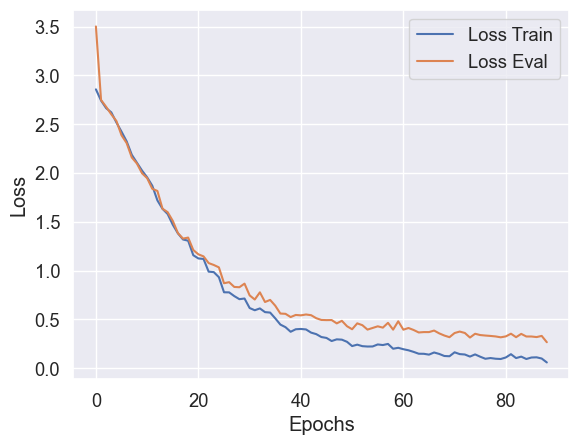

In [285]:
fig = plt.figure()
plt.plot(efficientnet_recover['loss_train'][1:])
plt.plot(efficientnet_recover['loss_eval'][1:])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Loss Train', 'Loss Eval'])
plt.show()

In [286]:
efficientnet_ytrue, efficientnet_lres = modelMetrics(efficientnet_model)

#### Confusion Matrix

In [287]:
print(metrics.confusion_matrix(efficientnet_ytrue, efficientnet_lres))

[[11  0  1  1  0  0  0  0  0  0  0  1  0  0  0  1  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  0  7  0  0  0  1  0  0  1  0  0  0  0  0  0  0  0  0  2]
 [ 1  0  2 10  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  1  0  0  0  0  0  0  0  0  1  0  2]
 [ 0  0  0  1  0  0  8  0  0  1  0  2  0  1  1  0  0  0  1  0]
 [ 0  0  0  1  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  3  0  0 11  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  2  0  0 12  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  1  0  0  0  0  0 11  0  0  0  0  2  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  1  0  0  0  0  0  0 12  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  1  0  2  0  1  9  0  0  0  1  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  0 11  1  1

#### Classification

In [288]:
print(metrics.classification_report(efficientnet_ytrue, efficientnet_lres, target_names=dataset.classes, digits=3))

                          precision    recall  f1-score   support

         Amanita gemmata      0.611     0.733     0.667        15
        Amanita muscaria      1.000     1.000     1.000        15
      Amanita pantherina      0.538     0.467     0.500        15
      Amanita phalloides      0.556     0.667     0.606        15
        Clathrus archeri      0.938     1.000     0.968        15
Coprinellus disseminatus      0.524     0.733     0.611        15
        Coprinus comatus      0.571     0.533     0.552        15
   Entoloma hochstetteri      1.000     0.933     0.966        15
 Filoboletus manipularis      0.846     0.733     0.786        15
       Fomes fomentarius      0.750     0.800     0.774        15
     Gyromitra esculenta      1.000     0.733     0.846        15
      Hericium erinaceus      0.682     1.000     0.811        15
        Hydnellum peckii      1.000     1.000     1.000        15
    Ileodictyon cibarium      0.857     0.800     0.828        15
        L

### Model - regnet_y_800mf (6.4M Params)

In [289]:
regnet_model = regnet_y_800mf()
number_of_features = regnet_model.fc.in_features
regnet_model.fc = torch.nn.Linear(number_of_features, len(dataset.classes))
regnet_model.name = 'regnet_y_800mf'
regnet_model.to(device)

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=4, bias=False)
            

In [290]:
regnet_optimizer = optim.SGD(regnet_model.parameters(), lr=0.001, momentum=0.9)

In [291]:
trainModel(regnet_model, regnet_optimizer)

Best model found! saving...
epoch 0 loss_train 2.971 loss_eval 2.954 last_best 1
Best model found! saving...
epoch 1 loss_train 2.788 loss_eval 2.791 last_best 1
Best model found! saving...
epoch 2 loss_train 2.705 loss_eval 2.691 last_best 1
Best model found! saving...
epoch 3 loss_train 2.580 loss_eval 2.565 last_best 1
Best model found! saving...
epoch 4 loss_train 2.455 loss_eval 2.451 last_best 1
Best model found! saving...
epoch 5 loss_train 2.262 loss_eval 2.234 last_best 1
Best model found! saving...
epoch 6 loss_train 2.165 loss_eval 2.144 last_best 1
Best model found! saving...
epoch 7 loss_train 2.012 loss_eval 2.002 last_best 1
Best model found! saving...
epoch 8 loss_train 1.925 loss_eval 1.919 last_best 1
Best model found! saving...
epoch 9 loss_train 1.799 loss_eval 1.805 last_best 1
Best model found! saving...
epoch 10 loss_train 1.692 loss_eval 1.711 last_best 1
Best model found! saving...
epoch 11 loss_train 1.624 loss_eval 1.660 last_best 1
Best model found! saving..

In [292]:
regnet_model, regnet_recover = recoverTrainedModel(regnet_model, regnet_optimizer)

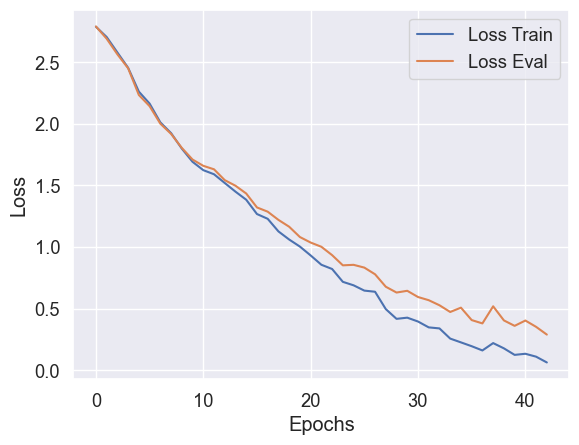

In [293]:
fig = plt.figure()
plt.plot(regnet_recover['loss_train'][1:])
plt.plot(regnet_recover['loss_eval'][1:])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Loss Train', 'Loss Eval'])
plt.show()

In [294]:
regnet_ytrue, regnet_lres = modelMetrics(regnet_model)

#### Confusion Matrix

In [295]:
print(metrics.confusion_matrix(regnet_ytrue, regnet_lres))

[[ 4  0  2  6  0  0  1  0  0  0  0  0  0  0  0  0  0  2  0  0]
 [ 0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  2  0  0  1  1  0  0  0  0  0  0  3  0  0  3  2  0]
 [ 0  0  0 11  0  0  0  0  0  0  0  1  0  0  2  0  0  0  1  0]
 [ 0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  9  1  0  2  0  0  1  0  0  0  0  0  0  1  1]
 [ 0  0  0  1  0  1  5  0  0  1  0  3  0  1  2  0  0  0  1  0]
 [ 0  0  0  0  0  0  0 13  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  0  1  0  2  0  0  8  1  0  0  0  1  0  0  0  0  0  2]
 [ 0  0  1  1  0  0  2  0  0  9  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  1  0  0  0  0  0  9  0  0  0  0  2  0  0  0  1]
 [ 1  0  0  0  0  0  0  0  1  0  0 13  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 14  0  1  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  1  1  0  0  0  0 10  1  1  0  0  0  0]
 [ 4  0  0  1  0  0  0  0  0  0  0  2  0  0  6  0  0  0  2  0]
 [ 0  0  1  0  0  0  2  0  0  1  0  0  0  0  0  9  0  1

#### Classification

In [296]:
print(metrics.classification_report(regnet_ytrue, regnet_lres, target_names=dataset.classes, digits=3))

                          precision    recall  f1-score   support

         Amanita gemmata      0.364     0.267     0.308        15
        Amanita muscaria      1.000     1.000     1.000        15
      Amanita pantherina      0.231     0.200     0.214        15
      Amanita phalloides      0.393     0.733     0.512        15
        Clathrus archeri      0.938     1.000     0.968        15
Coprinellus disseminatus      0.600     0.600     0.600        15
        Coprinus comatus      0.294     0.333     0.312        15
   Entoloma hochstetteri      0.812     0.867     0.839        15
 Filoboletus manipularis      0.571     0.533     0.552        15
       Fomes fomentarius      0.643     0.600     0.621        15
     Gyromitra esculenta      1.000     0.600     0.750        15
      Hericium erinaceus      0.565     0.867     0.684        15
        Hydnellum peckii      1.000     0.933     0.966        15
    Ileodictyon cibarium      0.769     0.667     0.714        15
        L

### Model - shufflenet_v2_x2_0 (7.4M Params)

In [297]:
shufflenet_model = shufflenet_v2_x2_0()
number_of_features = shufflenet_model.fc.in_features
shufflenet_model.fc = torch.nn.Linear(number_of_features, len(dataset.classes))
shufflenet_model.name = 'shufflenet_v2_x2_0'
shufflenet_model.to(device)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_runn

In [298]:
shufflenet_optimizer = optim.SGD(shufflenet_model.parameters(), lr=0.001, momentum=0.9)

In [299]:
trainModel(shufflenet_model, shufflenet_optimizer)

Best model found! saving...
epoch 0 loss_train 2.996 loss_eval 3.004 last_best 1
Best model found! saving...
epoch 1 loss_train 2.906 loss_eval 2.895 last_best 1
Best model found! saving...
epoch 2 loss_train 2.789 loss_eval 2.785 last_best 1
Best model found! saving...
epoch 3 loss_train 2.743 loss_eval 2.735 last_best 1
Best model found! saving...
epoch 4 loss_train 2.667 loss_eval 2.654 last_best 1
Best model found! saving...
epoch 5 loss_train 2.590 loss_eval 2.582 last_best 1
Best model found! saving...
epoch 6 loss_train 2.518 loss_eval 2.493 last_best 1
Best model found! saving...
epoch 7 loss_train 2.465 loss_eval 2.441 last_best 1
Best model found! saving...
epoch 8 loss_train 2.354 loss_eval 2.338 last_best 1
Best model found! saving...
epoch 9 loss_train 2.284 loss_eval 2.282 last_best 1
Best model found! saving...
epoch 10 loss_train 2.215 loss_eval 2.218 last_best 1
Best model found! saving...
epoch 11 loss_train 2.203 loss_eval 2.195 last_best 1
Best model found! saving..

In [300]:
shufflenet_model, shufflenet_recover = recoverTrainedModel(shufflenet_model, shufflenet_optimizer)

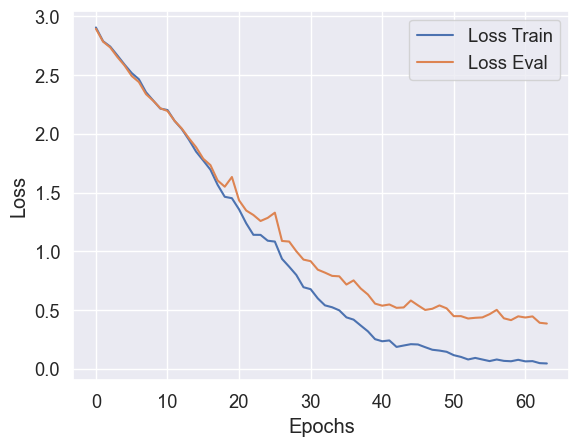

In [301]:
fig = plt.figure()
plt.plot(shufflenet_recover['loss_train'][1:])
plt.plot(shufflenet_recover['loss_eval'][1:])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Loss Train', 'Loss Eval'])
plt.show()

In [302]:
shufflenet_ytrue, shufflenet_lres = modelMetrics(shufflenet_model)

#### Confusion Matrix

In [303]:
print(metrics.confusion_matrix(shufflenet_ytrue, shufflenet_lres))

[[ 3  0  2  5  0  1  0  0  0  0  0  1  0  0  1  1  1  0  0  0]
 [ 0 14  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  3  2  0  0  1  0  0  2  0  0  0  0  0  2  1  2  1  1]
 [ 5  0  2  3  0  0  0  0  0  1  0  1  0  0  1  0  0  1  1  0]
 [ 0  0  0  0 11  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 10  1  0  0  2  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  1  0  0  1  6  0  0  2  0  3  0  0  0  0  0  1  1  0]
 [ 2  0  0  0  0  0  0 11  1  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  2  1  0  0  0  0  5  1  0  0  0  2  2  0  1  0  0  1]
 [ 0  0  1  0  0  0  2  0  0  9  0  2  0  0  0  1  0  0  0  0]
 [ 0  0  1  0  1  0  0  0  0  0 11  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  2  0 11  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0 13  1  0  0  0  0  0  0]
 [ 0  0  0  1  0  2  0  0  1  0  0  0  1  8  0  0  1  0  0  1]
 [ 3  0  3  1  0  0  0  0  0  1  0  1  0  0  2  0  2  0  2  0]
 [ 0  0  3  0  0  0  1  0  0  0  1  0  0  0  0  8  1  0

#### Classification

In [304]:
print(metrics.classification_report(shufflenet_ytrue, shufflenet_lres, target_names=dataset.classes, digits=3))

                          precision    recall  f1-score   support

         Amanita gemmata      0.200     0.200     0.200        15
        Amanita muscaria      1.000     0.933     0.966        15
      Amanita pantherina      0.136     0.200     0.162        15
      Amanita phalloides      0.143     0.200     0.167        15
        Clathrus archeri      0.846     0.733     0.786        15
Coprinellus disseminatus      0.625     0.667     0.645        15
        Coprinus comatus      0.429     0.400     0.414        15
   Entoloma hochstetteri      1.000     0.733     0.846        15
 Filoboletus manipularis      0.625     0.333     0.435        15
       Fomes fomentarius      0.346     0.600     0.439        15
     Gyromitra esculenta      0.846     0.733     0.786        15
      Hericium erinaceus      0.579     0.733     0.647        15
        Hydnellum peckii      0.684     0.867     0.765        15
    Ileodictyon cibarium      0.727     0.533     0.615        15
        L

## With Pre-treined Weights (DEFAULT)

### Model - efficientnet_b2 (IMAGENET1K_V1)

In [305]:
efficientnet_pretreined_model = efficientnet_b2(models.EfficientNet_B2_Weights.DEFAULT)
efficientnet_pretreined_model.classifier[1] = torch.nn.Linear(1408, len(dataset.classes))
efficientnet_pretreined_model.num_classes = len(dataset.classes)
efficientnet_pretreined_model.name = 'pretreined_efficientnet_b2'
efficientnet_pretreined_model.to(device)

c:\Users\Alison\Anaconda3\envs\mushroom-classification\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [306]:
efficientnet_pretreined_optimizer = optim.SGD(efficientnet_pretreined_model.parameters(), lr=0.001, momentum=0.9)

In [307]:
trainModel(efficientnet_pretreined_model, efficientnet_pretreined_optimizer)

Best model found! saving...
epoch 0 loss_train 2.848 loss_eval 2.795 last_best 1
Best model found! saving...
epoch 1 loss_train 2.201 loss_eval 2.136 last_best 1
Best model found! saving...
epoch 2 loss_train 1.454 loss_eval 1.401 last_best 1
Best model found! saving...
epoch 3 loss_train 0.905 loss_eval 0.878 last_best 1
Best model found! saving...
epoch 4 loss_train 0.620 loss_eval 0.610 last_best 1
Best model found! saving...
epoch 5 loss_train 0.455 loss_eval 0.455 last_best 1
Best model found! saving...
epoch 6 loss_train 0.362 loss_eval 0.364 last_best 1
Best model found! saving...
epoch 7 loss_train 0.291 loss_eval 0.298 last_best 1
Best model found! saving...
epoch 8 loss_train 0.251 loss_eval 0.259 last_best 1
Best model found! saving...
epoch 9 loss_train 0.203 loss_eval 0.214 last_best 1
Best model found! saving...
epoch 10 loss_train 0.160 loss_eval 0.174 last_best 1
Best model found! saving...
epoch 11 loss_train 0.151 loss_eval 0.165 last_best 1
Best model found! saving..

In [308]:
efficientnet_pretreined_model, efficientnet_pretreined_recover = recoverTrainedModel(efficientnet_pretreined_model, efficientnet_pretreined_optimizer)

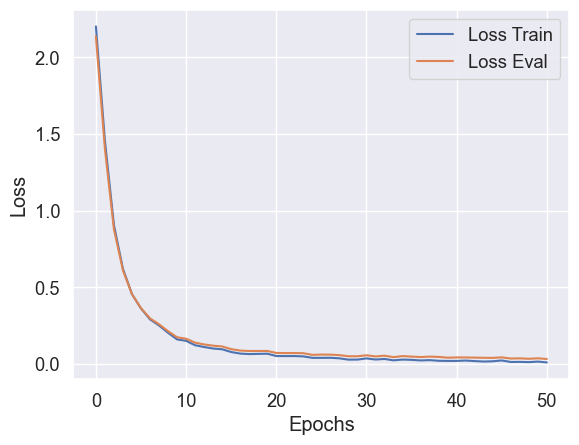

In [309]:
fig = plt.figure()
plt.plot(efficientnet_pretreined_recover['loss_train'][1:])
plt.plot(efficientnet_pretreined_recover['loss_eval'][1:])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Loss Train', 'Loss Eval'])
plt.show()

In [310]:
efficientnet_pretreined_ytrue, efficientnet_pretreined_lres = modelMetrics(efficientnet_pretreined_model)

#### Confusion Matrix

In [311]:
print(metrics.confusion_matrix(efficientnet_pretreined_ytrue, efficientnet_pretreined_lres))

[[14  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 12  0  0  2  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 14  0  1

#### Classification

In [312]:
print(metrics.classification_report(efficientnet_pretreined_ytrue, efficientnet_pretreined_lres, target_names=dataset.classes, digits=3))

                          precision    recall  f1-score   support

         Amanita gemmata      0.933     0.933     0.933        15
        Amanita muscaria      0.938     1.000     0.968        15
      Amanita pantherina      1.000     0.933     0.966        15
      Amanita phalloides      0.933     0.933     0.933        15
        Clathrus archeri      1.000     1.000     1.000        15
Coprinellus disseminatus      1.000     1.000     1.000        15
        Coprinus comatus      1.000     1.000     1.000        15
   Entoloma hochstetteri      1.000     1.000     1.000        15
 Filoboletus manipularis      1.000     0.933     0.966        15
       Fomes fomentarius      1.000     0.933     0.966        15
     Gyromitra esculenta      1.000     1.000     1.000        15
      Hericium erinaceus      1.000     1.000     1.000        15
        Hydnellum peckii      1.000     1.000     1.000        15
    Ileodictyon cibarium      1.000     1.000     1.000        15
        L

### Model - regnet_y_800mf (IMAGENET1K_V2)

In [313]:
regnet_pretreined_model = regnet_y_800mf(models.RegNet_Y_800MF_Weights.DEFAULT)
number_of_features = regnet_pretreined_model.fc.in_features
regnet_pretreined_model.fc = torch.nn.Linear(number_of_features, len(dataset.classes))
regnet_pretreined_model.name = 'pretreined_regnet_y_800mf'
regnet_pretreined_model.to(device)

c:\Users\Alison\Anaconda3\envs\mushroom-classification\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(


RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=4, bias=False)
            

In [314]:
regnet_pretreined_optimizer = optim.SGD(regnet_pretreined_model.parameters(), lr=0.001, momentum=0.9)

In [315]:
trainModel(regnet_pretreined_model, regnet_pretreined_optimizer)

Best model found! saving...
epoch 0 loss_train 2.719 loss_eval 2.621 last_best 1
Best model found! saving...
epoch 1 loss_train 1.395 loss_eval 1.298 last_best 1
Best model found! saving...
epoch 2 loss_train 0.558 loss_eval 0.546 last_best 1
Best model found! saving...
epoch 3 loss_train 0.295 loss_eval 0.305 last_best 1
Best model found! saving...
epoch 4 loss_train 0.183 loss_eval 0.205 last_best 1
Best model found! saving...
epoch 5 loss_train 0.137 loss_eval 0.160 last_best 1
Best model found! saving...
epoch 6 loss_train 0.099 loss_eval 0.124 last_best 1
Best model found! saving...
epoch 7 loss_train 0.078 loss_eval 0.105 last_best 1
Best model found! saving...
epoch 8 loss_train 0.056 loss_eval 0.085 last_best 1
Best model found! saving...
epoch 9 loss_train 0.048 loss_eval 0.080 last_best 1
Best model found! saving...
epoch 10 loss_train 0.038 loss_eval 0.069 last_best 1
Best model found! saving...
epoch 11 loss_train 0.035 loss_eval 0.065 last_best 1
Best model found! saving..

In [316]:
regnet_pretreined_model, regnet_pretreined_recover = recoverTrainedModel(regnet_pretreined_model, regnet_pretreined_optimizer)

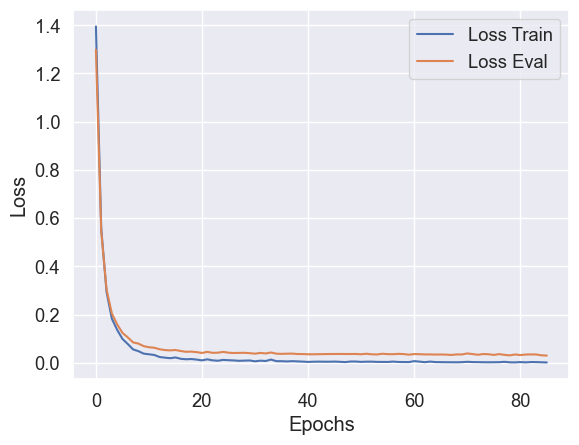

In [317]:
fig = plt.figure()
plt.plot(regnet_pretreined_recover['loss_train'][1:])
plt.plot(regnet_pretreined_recover['loss_eval'][1:])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Loss Train', 'Loss Eval'])
plt.show()

In [318]:
regnet_pretreined_ytrue, regnet_pretreined_lres = modelMetrics(regnet_pretreined_model)

#### Confusion Matrix

In [319]:
print(metrics.confusion_matrix(regnet_pretreined_ytrue, regnet_pretreined_lres))

[[14  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0 14  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0 14  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 13  0  0  1  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0 14  0  0

#### Classification

In [320]:
print(metrics.classification_report(regnet_pretreined_ytrue, regnet_pretreined_lres, target_names=dataset.classes, digits=3))

                          precision    recall  f1-score   support

         Amanita gemmata      0.824     0.933     0.875        15
        Amanita muscaria      1.000     1.000     1.000        15
      Amanita pantherina      1.000     0.933     0.966        15
      Amanita phalloides      0.923     0.800     0.857        15
        Clathrus archeri      0.882     1.000     0.938        15
Coprinellus disseminatus      1.000     0.933     0.966        15
        Coprinus comatus      1.000     1.000     1.000        15
   Entoloma hochstetteri      1.000     1.000     1.000        15
 Filoboletus manipularis      0.882     1.000     0.938        15
       Fomes fomentarius      0.933     0.933     0.933        15
     Gyromitra esculenta      1.000     1.000     1.000        15
      Hericium erinaceus      0.933     0.933     0.933        15
        Hydnellum peckii      1.000     1.000     1.000        15
    Ileodictyon cibarium      1.000     0.933     0.966        15
        L

### Model - shufflenet_v2_x2_0 (IMAGENET1K_V1)

In [14]:
shufflenet_pretreined_model = shufflenet_v2_x2_0(models.shufflenetv2.ShuffleNet_V2_X2_0_Weights.DEFAULT)
number_of_features = shufflenet_pretreined_model.fc.in_features
shufflenet_pretreined_model.fc = torch.nn.Linear(number_of_features, len(dataset.classes))
shufflenet_pretreined_model.name = 'pretreined_shufflenet_v2_x2_0'
shufflenet_pretreined_model.to(device)

c:\Users\Alison\Anaconda3\envs\mushroom-classification\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(


ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_runn

In [15]:
shufflenet_pretreined_optimizer = optim.SGD(shufflenet_pretreined_model.parameters(), lr=0.001, momentum=0.9)

In [323]:
trainModel(shufflenet_pretreined_model, shufflenet_pretreined_optimizer)

Best model found! saving...
epoch 0 loss_train 2.788 loss_eval 2.745 last_best 1
Best model found! saving...
epoch 1 loss_train 2.008 loss_eval 1.936 last_best 1
Best model found! saving...
epoch 2 loss_train 1.057 loss_eval 0.990 last_best 1
Best model found! saving...
epoch 3 loss_train 0.562 loss_eval 0.544 last_best 1
Best model found! saving...
epoch 4 loss_train 0.379 loss_eval 0.374 last_best 1
Best model found! saving...
epoch 5 loss_train 0.269 loss_eval 0.275 last_best 1
Best model found! saving...
epoch 6 loss_train 0.204 loss_eval 0.214 last_best 1
Best model found! saving...
epoch 7 loss_train 0.181 loss_eval 0.192 last_best 1
Best model found! saving...
epoch 8 loss_train 0.135 loss_eval 0.150 last_best 1
Best model found! saving...
epoch 9 loss_train 0.107 loss_eval 0.127 last_best 1
Best model found! saving...
epoch 10 loss_train 0.084 loss_eval 0.106 last_best 1
Best model found! saving...
epoch 11 loss_train 0.083 loss_eval 0.105 last_best 1
Best model found! saving..

In [41]:
shufflenet_pretreined_model, shufflenet_pretreined_recover = recoverTrainedModel(shufflenet_pretreined_model, shufflenet_pretreined_optimizer)

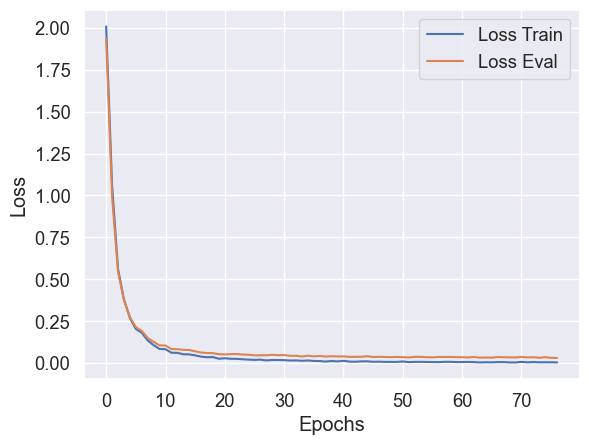

In [325]:
fig = plt.figure()
plt.plot(shufflenet_pretreined_recover['loss_train'][1:])
plt.plot(shufflenet_pretreined_recover['loss_eval'][1:])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Loss Train', 'Loss Eval'])
plt.show()

In [42]:
shufflenet_pretreined_ytrue, shufflenet_pretreined_lres = modelMetrics(shufflenet_pretreined_model)

#### Confusion Matrix

In [327]:
print(metrics.confusion_matrix(shufflenet_pretreined_ytrue, shufflenet_pretreined_lres))

[[14  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 14  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 14  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 13  0  0  1  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15  0  0

#### Classification

In [328]:
print(metrics.classification_report(shufflenet_pretreined_ytrue, shufflenet_pretreined_lres, target_names=dataset.classes, digits=3))

                          precision    recall  f1-score   support

         Amanita gemmata      0.933     0.933     0.933        15
        Amanita muscaria      0.938     1.000     0.968        15
      Amanita pantherina      0.938     1.000     0.968        15
      Amanita phalloides      1.000     1.000     1.000        15
        Clathrus archeri      1.000     1.000     1.000        15
Coprinellus disseminatus      0.933     0.933     0.933        15
        Coprinus comatus      1.000     1.000     1.000        15
   Entoloma hochstetteri      1.000     1.000     1.000        15
 Filoboletus manipularis      0.882     1.000     0.938        15
       Fomes fomentarius      1.000     0.867     0.929        15
     Gyromitra esculenta      1.000     1.000     1.000        15
      Hericium erinaceus      1.000     1.000     1.000        15
        Hydnellum peckii      1.000     1.000     1.000        15
    Ileodictyon cibarium      1.000     0.933     0.966        15
        L